In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import sys
sys.path.append('./lss_likelihood/')
from linear_theory import*
from pnw_dst import pnw_dst

In [107]:
zfid = 0.85
OmM_fid = 0.3

fz = f_of_a(1./(1+zfid),OmegaM=OmM_fid)
Dz = D_of_a(1./(1+zfid),OmegaM=OmM_fid)


ki, pi  = np.loadtxt('Pk_Planck15_Table4.txt', unpack=True)
knw, pnw = np.loadtxt('Pk_Planck15_NW_Table4.txt', unpack=True)
pw = pi - pnw

(0.0, 0.3)

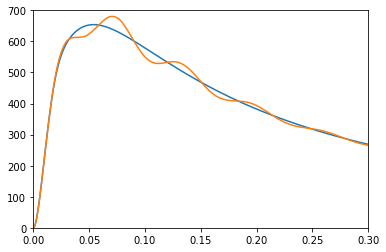

In [108]:
plt.plot(ki, ki * pnw)
plt.plot(ki, ki * pi)

plt.ylim(0,700)

plt.xlim(0,0.3)

In [109]:
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from scipy.integrate import simps

qbao = 100
j0 = spherical_jn(0,ki*qbao)
Sk = np.exp(-0.5*(ki*15)**2)

sigmadd = Dz**2 * simps( 2./3 * pi * (1-Sk)**2 * (1-j0), x = ki) / (2*np.pi**2)
sigmass = Dz**2 * simps( 2./3 * pi * (-Sk)**2 * (1-j0), x = ki) / (2*np.pi**2)

sigmads_dd = Dz**2 * simps( 2./3 * pi * (1-Sk)**2, x = ki) / (2*np.pi**2)
sigmads_ss = Dz**2 * simps( 2./3 * pi * (-Sk)**2, x = ki) / (2*np.pi**2)
sigmads_ds = -Dz**2 * simps( 2./3 * pi * (1-Sk)*(-Sk)*j0, x = ki) / (2*np.pi**2) # this minus sign is because we subtract the cross term
 
Zels= {'R': 15.,
       'fz':fz,\
       'klin': ki, 'pnw': Dz**2 * pnw, 'pw': Dz**2 * pw,\
       'sigmas': (sigmadd, sigmass, sigmads_dd, sigmads_ss, sigmads_ds)}

In [110]:
from numpy.polynomial.polynomial import polyval

def compute_bao_pkmu(B1,F, mu_obs):
    '''
        Helper function to get P(k,mu) post-recon in RecIso.
        
        This is turned into Pkell and then Hankel transformed in the bao_predict funciton.
    '''
    
        
    f0 = Zels['fz']
    apar, aperp = 1, 1
        
    klin = Zels['klin']
    pnw = Zels['pnw']
    pw  = Zels['pw']
        
    sigmadd, sigmass, sigmads_dd, sigmads_ss, sigmads_ds = Zels['sigmas']
    R = Zels['R']

    Sk = np.exp(-0.5*(klin*R)**2)
 
    F_AP = apar/aperp
    AP_fac = np.sqrt(1 + mu_obs**2 *(1./F_AP**2 - 1) )
    mu = mu_obs / F_AP / AP_fac
    ktrue = klin/aperp*AP_fac
        
    # First construct P_{dd,ss,ds} individually
    dampfac_dd = np.exp( -0.5 * klin**2 * sigmadd * (1 + f0*(2+f0)*mu**2) )
    pdd = ( (1 + F*mu**2)*(1-Sk) + B1 )**2 * (dampfac_dd * pw + pnw)
        
    # then Pss
    dampfac_ss = np.exp( -0.5 * klin**2 * sigmass )
    pss = Sk**2 * (dampfac_ss * pw + pnw)
        
    # Finally Pds
    dampfac_ds = np.exp(-0.5 * klin**2 * ( 0.5*sigmads_dd*(1+f0*(2+f0)*mu**2)\
                                             + 0.5*sigmads_ss \
                                             + (1+f0*mu**2)*sigmads_ds) )
    linfac = - Sk * ( (1+F*mu**2)*(1-Sk) + B1 )
    pds = linfac * (dampfac_ds * pw + pnw)
        
    # Sum it all up and interpolate?
    ptrue = pdd + pss - 2*pds
    pmodel = interp1d(klin, ptrue, kind='cubic', fill_value=0,bounds_error=False)(ktrue)
    
    return pmodel

In [130]:
# Now define the functions!
def bao_predict(B1,F,M0,M1,M2,M3,M4,Q0,Q1,Q2,Q3,Q4):
        

    # Generate the sampling
    ngauss = 4
    nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
    nus_calc = nus[0:ngauss]
        
    L0 = np.polynomial.legendre.Legendre((1))(nus)
    L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
    #L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
        
        
    klin = Zels['klin']
    pknutable = np.zeros((len(nus),len(klin)))
    
    for ii, nu in enumerate(nus_calc):
        pknutable[ii,:] = compute_bao_pkmu(B1,F,nu)
 
    pknutable[ngauss:,:] = np.flip(pknutable[0:ngauss],axis=0)
        
    p0 = 0.5 * np.sum((ws*L0)[:,None]*pknutable,axis=0) #+ 1000 * polyval(klin,[m0,m1,m2,m3,m4,m5]) / klin
    p2 = 2.5 * np.sum((ws*L2)[:,None]*pknutable,axis=0) #+ 1000 * polyval(klin,[q0,q1,q2,q3,q4,q5]) / klin

        
    p0 += polyval(klin,[M0,M1,M2,M3,M4])
    p2 += polyval(klin,[Q0,Q1,Q2,Q3,Q4])

    return np.array([klin,p0,p2]).T

(0.0, 0.2)

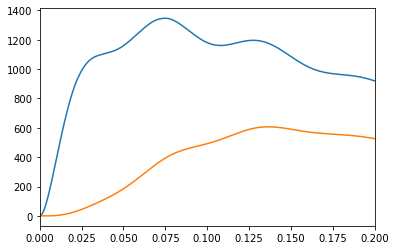

In [112]:
tt = bao_predict(1,1,0,0,0,0,0,0,0,0,0,0)

#dats = np.loadtxt('../CobayaLSS/xitest.dat')

plt.plot(tt[:,0], tt[:,0] * tt[:,1])
plt.plot(tt[:,0], tt[:,0] * tt[:,2])

plt.xlim(0,0.2)

In [113]:
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

kdat, p0dat, p2dat, p4dat, Nk = np.loadtxt('data/Martin_RecIso/UNIT_Pk/pk_unit_martin_reciso.txt',unpack=True)

def bao_observe(tt):
    '''
    Bin the BAO results... probabaly should eventually use a matrix.
    '''
        
    thy0 = Spline(tt[:,0],tt[:,1],ext='extrapolate')(kdat)
    thy2 = Spline(tt[:,0],tt[:,2],ext='extrapolate')(kdat)

    return np.concatenate((thy0,thy2))

In [114]:
print(Zels['sigmas'])

(10.12025882175815, 9.332620656917147, 10.128518651354545, 13.685592617083431, 0.03169562702463055)


In [115]:
# Cut out parts of the covariance
cov = np.loadtxt('data/Martin_RecIso/EZ_Cov/cov_martin_reciso_block_diag_p0p2.txt')

In [120]:
# Now fit... naively
kmin, kmax = 0.02, 0.25
iis = (kdat > kmin) * (kdat < kmax)
fit_iis = np.concatenate( (iis,iis) )

Cinv = np.linalg.inv(cov[np.ix_(fit_iis,fit_iis)])

dats = np.concatenate((p0dat,p2dat))

def diff(p):
    B1,F, M0,M1,M2,M3,M4,Q0,Q1,Q2,Q3,Q4 = p
    
    tt = bao_predict(B1,F,M0,M1,M2,M3,M4,Q0,Q1,Q2,Q3,Q4)
    tt = bao_observe(tt)
    
    return tt - dats

def chi2(p):
    
    dd = diff(p)[fit_iis]
    chi2 = np.dot(dd,np.dot(Cinv,dd))
    
    return chi2

In [121]:
chi2([1,1,0,0,0,0,0,0,0,0,0,0])

379088.48588271457

In [122]:
from scipy.optimize import minimize

res = minimize(chi2, [1,1,0,0,0,0,0,0,0,0,0,0])
print(res)

      fun: 23.466149903913408
 hess_inv: array([[ 1.38870489e+00,  2.19423651e-02, -1.83473519e-01,
        -2.98639541e+01,  5.15615374e+01,  4.18518056e+01,
         1.61515016e+01,  8.86297394e+01, -2.82725936e+03,
         1.30152059e+02, -9.42698720e+00, -1.97198267e+01],
       [ 2.19423651e-02,  9.53924734e-04,  7.10339279e-03,
        -4.52647488e-01,  7.86930775e-01,  6.55216418e-01,
         2.55226995e-01,  1.42865644e+00, -4.56320545e+01,
         2.23183815e+00, -2.28577342e-01, -3.80246107e-01],
       [-1.83473519e-01,  7.10339279e-03,  3.22403212e-01,
         4.01874159e+00, -6.50500527e+00, -5.42705109e+00,
        -2.13275714e+00, -1.11228708e+01,  3.54521476e+02,
        -1.24593691e+01, -2.15085686e-02,  1.29342803e+00],
       [-2.98639541e+01, -4.52647488e-01,  4.01874159e+00,
         7.04802612e+02, -1.22582570e+03, -9.37105932e+02,
        -3.58231337e+02, -1.89980535e+03,  6.06088738e+04,
        -2.70074941e+03,  6.96966487e+01,  3.34574943e+02],
       [ 5.

(0.0, 700.0)

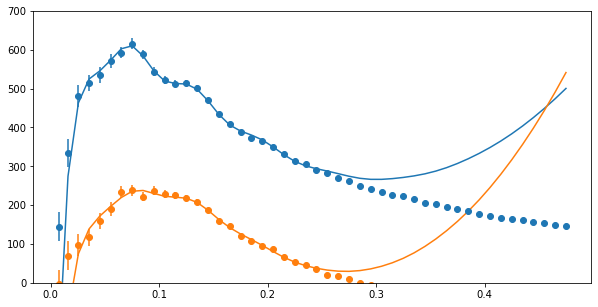

In [123]:
plt.figure(figsize=(10,5))

#B1, F, M0, M1, Q0, Q1 = res.x
#M2, Q2 = 0,0 

tt = bao_predict(*res.x)
tt = bao_observe(tt)

err0 = np.diag(cov)[:48]**0.5
err2 = np.diag(cov)[48:]**0.5

plt.plot(kdat, kdat * tt[:48])
plt.errorbar(kdat, kdat * p0dat, yerr=kdat*err0, c='C0', fmt='o')

plt.plot(kdat, kdat * tt[48:])
plt.errorbar(kdat, kdat * p2dat, yerr=kdat*err0, c='C1', fmt='o')

plt.ylim(0,700)

#plt.plot(rdat, -rdat**2 * tt[36:])
#plt.errorbar(rdat, -rdat**2 * xi2dat, yerr=rdat**2*err2, c='C1', fmt='o')

#plt.plot([rmin,rmin],[-100,100], 'k--')
#plt.plot([rmax,rmax], [-100,100], 'k--')

#plt.xlim(0,150)
#plt.ylim(-50,100)

#plt.xlabel('r')
#plt.ylabel(r'$i^\ell r^2 \xi_\ell$')

#plt.savefig('planck_bao_z3_bestfit_linear.pdf')

In [124]:
kdat

array([0.00748952, 0.01606578, 0.02566306, 0.03547406, 0.04536407,
       0.05529814, 0.06525907, 0.07522584, 0.08520013, 0.09517893,
       0.10516671, 0.11515255, 0.12513824, 0.13512883, 0.145115  ,
       0.15510966, 0.16510609, 0.17509935, 0.18509173, 0.19508584,
       0.20508471, 0.21507913, 0.22507373, 0.23507125, 0.24506841,
       0.25506433, 0.2650619 , 0.27505915, 0.28505511, 0.29505671,
       0.30505768, 0.31505446, 0.32505111, 0.33504893, 0.3450496 ,
       0.3550502 , 0.3650455 , 0.37504248, 0.38504308, 0.39504291,
       0.40504158, 0.41504075, 0.42503967, 0.43503871, 0.44503855,
       0.45503815, 0.46503709, 0.47503632])

In [133]:
dats = np.loadtxt('thy.dat')
obs  = np.loadtxt('obs.dat')

(0.0, 0.4)

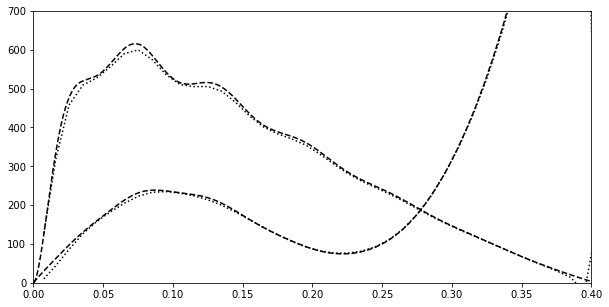

In [137]:
plt.figure(figsize=(10,5))

#B1, F, M0, M1, Q0, Q1 = res.x
#M2, Q2 = 0,0 

tt = bao_predict(*res.x)
tt = bao_observe(tt)

err0 = np.diag(cov)[:48]**0.5
err2 = np.diag(cov)[48:]**0.5

#plt.plot(kdat, kdat * tt[:48])
#plt.errorbar(kdat, kdat * p0dat, yerr=kdat*err0, c='C0', fmt='o')
plt.plot(dats[:,0], dats[:,0]*dats[:,1], 'k--')
plt.plot(kdat, kdat*obs[:48], 'k:')


#plt.plot(kdat, kdat * tt[48:])
#plt.errorbar(kdat, kdat * p2dat, yerr=kdat*err0, c='C1', fmt='o')
plt.plot(dats[:,0], dats[:,0]*dats[:,2], 'k--')
plt.plot(kdat, kdat*obs[48:], 'k:')



plt.ylim(0,700)
plt.xlim(0,0.4)

In [135]:
obs.shape

(96,)